# Get the vibe - Experimental Notebook

## Set up

### Imports

In [1]:
# General libraries
import numpy as np
import pandas as pd

# Image related
import matplotlib.pyplot as plt 
from matplotlib import image
from keras.preprocessing.image import load_img, img_to_array
import os

# CNN
import tensorflow as tf
from tensorflow.keras import models
from tensorflow.keras import Sequential, layers
from tensorflow.keras.callbacks import EarlyStopping

# Confusion Matrix & Additional Metrics
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report

#### Set up

In [2]:
# Import Data 
image_df = pd.read_csv("../getthevibe_api/data/fer2013.csv")

In [3]:
# Data Path
# folder_path = "../../JaildoR/getthevibe_api/getthevibe_api/data/fer2013.csv"

In [4]:
# Define Emotions
Emotions = ["Angry", "Disgust", "Fear", "Happy", "Sad", "Surprise", "Neutral"]  # indices 0 to 6

In [5]:
# Insert column emotions
image_df["emotion_new"] = image_df["emotion"].map({0: "Angry", 1: "Disgust", 2: "Fear", 3: "Happy", 4: "Sad", 5: "Surprise", 6: "Neutral"})

In [6]:
# Define formate
FER2013_WIDTH = 48
FER2013_HEIGHT = 48

## Preprosessing

### Exclude "disgust"

In [7]:
image_df = image_df[image_df.emotion != 1]

### Training Data Split

In [8]:
train_set = image_df[(image_df.Usage == 'Training')] 
val_set = image_df[(image_df.Usage == 'PublicTest')]
test_set = image_df[(image_df.Usage == 'PrivateTest')] 

### Reshape X

In [9]:
# define x
X_train = np.array(list(map(str.split, train_set.pixels)), np.float32) 
X_val = np.array(list(map(str.split, val_set.pixels)), np.float32) 
X_test = np.array(list(map(str.split, test_set.pixels)), np.float32) 


X_train = X_train.reshape(X_train.shape[0], 48, 48, 1) 
X_val = X_val.reshape(X_val.shape[0], 48, 48, 1)
X_test = X_test.reshape(X_test.shape[0], 48, 48, 1)

### Scaling 

In [10]:
X_train = (X_train/255) -0.5
X_val = (X_val/255) - 0.5
X_test = (X_test/255) - 0.5

### One hot encode y

In [11]:
# define y
y_train = train_set["emotion"]
y_val = val_set["emotion"]
y_test = test_set["emotion"]

In [12]:
y_test

32298    0
32299    5
32300    6
32301    4
32302    2
        ..
35882    6
35883    3
35884    0
35885    3
35886    2
Name: emotion, Length: 3534, dtype: int64

In [13]:
# One Hot Encode our Target for TensorFlow processing
from tensorflow.keras.utils import to_categorical

y_cat_train = to_categorical(y_train, num_classes=7)
y_cat_test = to_categorical(y_test, num_classes=7)
y_cat_val = to_categorical(y_val, num_classes=7)

## General Evaluation Functions

In [30]:
def plot_history(history, title='', axs=None, exp_name=""):
    if axs is not None:
        ax1, ax2 = axs
    else:
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    
    if len(exp_name) > 0 and exp_name[0] != '_':
        exp_name = '_' + exp_name
    ax1.plot(history.history['loss'], label='train' + exp_name)
    ax1.plot(history.history['val_loss'], label='val' + exp_name)
    ax1.set_title('loss')
    ax1.legend()

    ax2.plot(history.history['accuracy'], label='train accuracy'  + exp_name)
    ax2.plot(history.history['val_accuracy'], label='val accuracy'  + exp_name)
    ax2.set_title('Accurary')
    ax2.legend()
    return (ax1, ax2)

In [33]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
"""
Displays a confusion matrix 
"""

def confusio(X_test, y_test, model):
    
    predicted_probabilities = model.predict(X_test)
    def prediction_from_probabilities(predicted_probabilities):
        return np.argmax(predicted_probabilities)
    y_pred = np.apply_along_axis(prediction_from_probabilities, 
                                 1,                            
                                 predicted_probabilities)
    
    
    labels = ['Angry', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral'] # adapted to without "digust"
    cm = confusion_matrix(y_test, y_pred)
    cm = cm / cm.astype(np.float).sum(axis=1) # convert into percentages
    
    
    disp = ConfusionMatrixDisplay(confusion_matrix = cm,
                              display_labels = labels);
    fig, ax = plt.subplots(figsize=(10,10));
    title='Confusion matrix'
    plt.title(title)
    disp.plot(cmap = "PuRd", ax = ax);
    pass

##  Model

### Jaildo Model

#### Jaildo Model

In [16]:
### 1. Architecture
model = models.Sequential()

model.add(layers.Conv2D(32, (5, 5), 
                 padding='same',
                 strides = (1,1),
                 input_shape=(48, 48, 1), 
                 activation='relu'))

model.add(layers.MaxPooling2D(pool_size=(2, 2)))

model.add(layers.Conv2D(32, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))

model.add(layers.Conv2D(16, (3, 3), padding='same', activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))

model.add(layers.Flatten())
model.add(layers.Dense(50, activation='relu'))
model.add(layers.Dense(7, activation='softmax'))

2022-03-09 15:55:19.713828: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [17]:
#### 2. Compilation
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [18]:
#### 3. Fit
es = EarlyStopping(restore_best_weights=True, patience=5)

history = model.fit(X_train, y_cat_train,
                    epochs=50,
                    batch_size=32, 
                    verbose=1,
                    use_multiprocessing = True,
                    validation_data=(X_val,y_cat_val),
                    callbacks=[es]) 

Epoch 1/50
884/884 [==============================] - 67s 74ms/step - loss: 1.5906 - accuracy: 0.3549 - val_loss: 1.4497 - val_accuracy: 0.4345
Epoch 2/50
884/884 [==============================] - 58s 66ms/step - loss: 1.3956 - accuracy: 0.4524 - val_loss: 1.3383 - val_accuracy: 0.4786
Epoch 3/50
884/884 [==============================] - 59s 67ms/step - loss: 1.2986 - accuracy: 0.4940 - val_loss: 1.2916 - val_accuracy: 0.5038
Epoch 4/50
884/884 [==============================] - 53s 60ms/step - loss: 1.2329 - accuracy: 0.5241 - val_loss: 1.2614 - val_accuracy: 0.5171
Epoch 5/50
545/884 [=================>............] - ETA: 23s - loss: 1.1800 - accuracy: 0.5439

KeyboardInterrupt: 

#### Jaildo Model Evaluation

In [ ]:
np.array(history.history["val_accuracy"])

In [ ]:
# Evaluate model on the test data
print(model.evaluate(X_test, y_cat_test, verbose=0))

In [ ]:
plot_history(history)

In [ ]:
from sklearn.metrics import classification_report

labels = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']
predicted_probabilities = model.predict(X_test)
def prediction_from_probabilities(predicted_probabilities):
    return np.argmax(predicted_probabilities)
y_pred = np.apply_along_axis(prediction_from_probabilities, 
                             1,                            
                             predicted_probabilities)

print(classification_report(y_test, y_pred, target_names=labels))

In [ ]:
confusio(X_test, y_test, model)

### Insanely performing model

#### Insanely performing model

In [43]:
### 1. Architecture
model_insane = models.Sequential()

model_insane.add(layers.Conv2D(16, (5, 5), 
                 padding='same',
                 strides = (1,1),
                 input_shape=(48, 48, 1), 
                 activation='relu'))

model_insane.add(layers.MaxPooling2D(pool_size=(2, 2)))
model_insane.add(layers.Dropout(0.2))

model_insane.add(layers.Conv2D(32, (3, 3), activation='relu'))
model_insane.add(layers.MaxPooling2D(pool_size=(2, 2)))
model_insane.add(layers.Dropout(0.2))

model_insane.add(layers.Conv2D(32, (3, 3), padding='same', activation='relu'))
model_insane.add(layers.MaxPooling2D(pool_size=(2, 2)))
model_insane.add(layers.Dropout(0.2))

model_insane.add(layers.Flatten())
model_insane.add(layers.Dense(50, activation='relu'))
model_insane.add(layers.Dropout(0.3))
model_insane.add(layers.Dense(7, activation='softmax'))

In [44]:
#### 2. Compilation

model_insane.compile(loss='categorical_crossentropy',
            optimizer='adam',
            metrics=['accuracy'])

In [45]:
#### 3. Fit
es = EarlyStopping(patience=5)

history = model_insane.fit(X_train, y_cat_train,
                    epochs=50,
                    batch_size=32, 
                    verbose=1,
                    use_multiprocessing = True,
                    validation_data=(X_val,y_cat_val),
                    callbacks=[es]) 

Epoch 1/50
884/884 [==============================] - 67s 75ms/step - loss: 1.6581 - accuracy: 0.3185 - val_loss: 1.5054 - val_accuracy: 0.4169
Epoch 2/50
884/884 [==============================] - 78s 88ms/step - loss: 1.4976 - accuracy: 0.4008 - val_loss: 1.3829 - val_accuracy: 0.4611
Epoch 3/50
884/884 [==============================] - 60s 68ms/step - loss: 1.4209 - accuracy: 0.4386 - val_loss: 1.3154 - val_accuracy: 0.4911
Epoch 4/50
884/884 [==============================] - 62s 70ms/step - loss: 1.3664 - accuracy: 0.4628 - val_loss: 1.2703 - val_accuracy: 0.5095
Epoch 5/50
884/884 [==============================] - 45s 51ms/step - loss: 1.3249 - accuracy: 0.4773 - val_loss: 1.2602 - val_accuracy: 0.5033
Epoch 6/50
884/884 [==============================] - 50s 57ms/step - loss: 1.2979 - accuracy: 0.4934 - val_loss: 1.2143 - val_accuracy: 0.5279
Epoch 7/50
884/884 [==============================] - 50s 56ms/step - loss: 1.2744 - accuracy: 0.5027 - val_loss: 1.1984 - val_accuracy:

#### evaluation

In [46]:
# Evaluate model on the test data
print(model.evaluate(X_test, y_cat_test, verbose=0))

[1.2638559341430664, 0.5053763389587402]


(<AxesSubplot:title={'center':'loss'}>,
 <AxesSubplot:title={'center':'Accurary'}>)

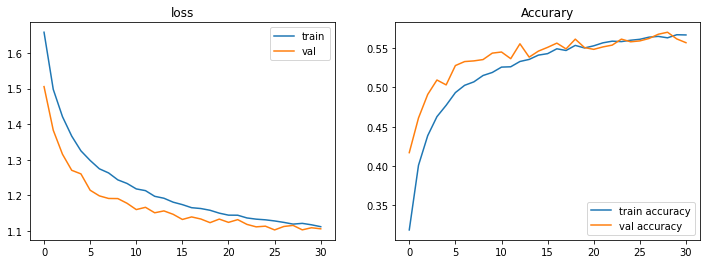

In [47]:
plot_history(history)

In [48]:
from sklearn.metrics import classification_report

labels = ['Angry', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral'] # adapted without disgust
predicted_probabilities = model.predict(X_test)
def prediction_from_probabilities(predicted_probabilities):
    return np.argmax(predicted_probabilities)
y_pred = np.apply_along_axis(prediction_from_probabilities, 
                             1,                            
                             predicted_probabilities)

print(classification_report(y_test, y_pred, target_names=labels))

              precision    recall  f1-score   support

       Angry       0.40      0.45      0.43       491
        Fear       0.32      0.27      0.29       528
       Happy       0.61      0.85      0.71       879
         Sad       0.39      0.27      0.32       594
    Surprise       0.65      0.58      0.61       416
     Neutral       0.51      0.44      0.48       626

    accuracy                           0.51      3534
   macro avg       0.48      0.48      0.47      3534
weighted avg       0.49      0.51      0.49      3534



/var/folders/jk/sqv2vrvx1819g_xv6zn3w3vw0000gn/T/ipykernel_5960/3407079137.py:18: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  cm = cm / cm.astype(np.float).sum(axis=1) # convert into percentages


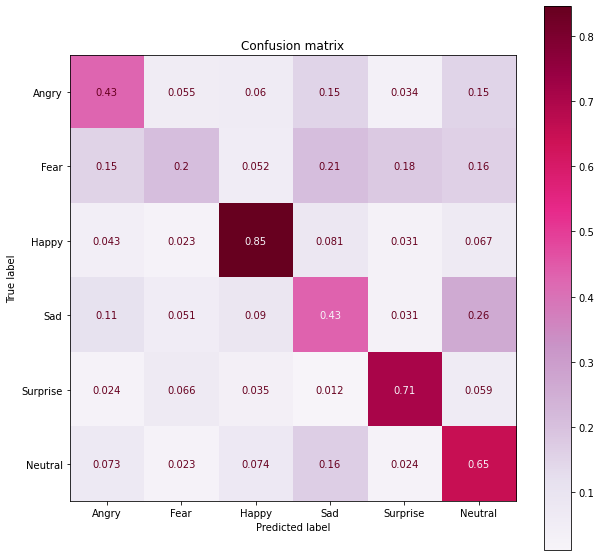

In [49]:
confusio(X_test, y_test, model_insane)

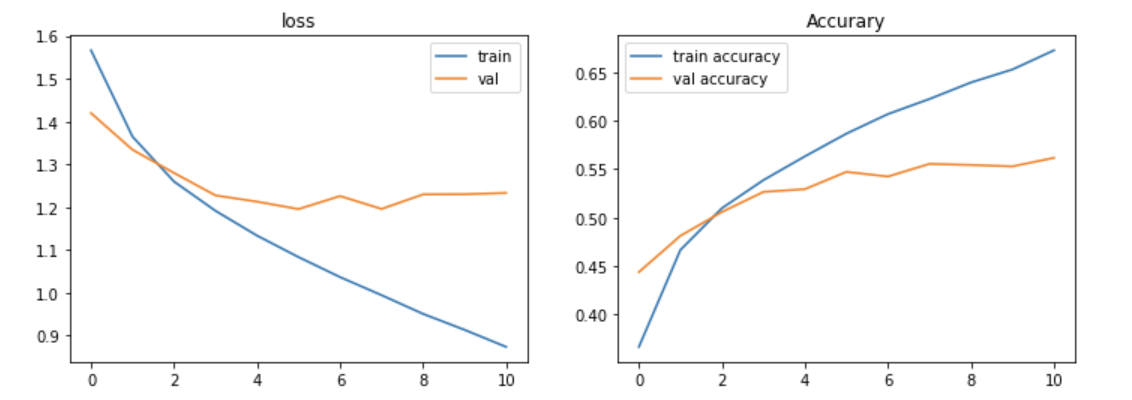